# Grids

This example allows us to explore a HDF5 grid file, and load the corresponding Grid object. We first load some common modules.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

We can then import the `Grid` object from synthesizer.

In [2]:
from synthesizer.grid import Grid

This object takes the lcoatino of the grids on your system (`grid_dir`) and the name of the grid you wish to load `grid_name`). here we load a simple test grid provided with the module (hence the relative path).

In [3]:
grid_dir = '../../../tests/test_grid'
grid_name = 'test_grid'

grid = Grid(grid_name, grid_dir=grid_dir)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3
  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7
  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1
 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11. ] 
metallicity: [1.0e-05 1.0e-04 1.0e-03 2.0e-03 3.0e-03 4.0e-03 6.0e-03 8.0e-03 1.0e-02
 1.4e-02 2.0e-02 3.0e-02 4.0e-02] 
C: Dopita2006 
CMB: False 
N: Dopita2006 
T_floor: 100 
U_model: ref 
alpha: 0.0 
axes: ['log10age' 'metallicity'] 
cloudy_version: c17.03 
cosmic_rays: True 
covering_factor: 1.0 
d2m: 0.3 
geometry: spherical 
grains: True 
imf_masses: [1.e-01 3.e+02] 
imf_slopes:  
imf_type: chabrier03 
iterate_to_convergence: False 
log10U_ref: -2 
log10age: [ 6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3
  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7
  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1


### Plot a single grid point

We can plot the spectra at the location of a single point in our grid. First, we choose some age and metallicity

In [4]:
log10age = 6.0  # log10(age/yr)
Z = 0.01  # metallicity

We then get the index location of that grid point for this age and metallicity

In [5]:
grid_point = grid.get_grid_point((log10age, Z))

We can then loop over the available spectra (contained in `grid.spec_names`) and plot

/Users/willroper/Documents/University/Synthesizer/synthesizer-env/lib/python3.10/site-packages/unyt/array.py:1758: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Text(0, 0.5, '$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$')

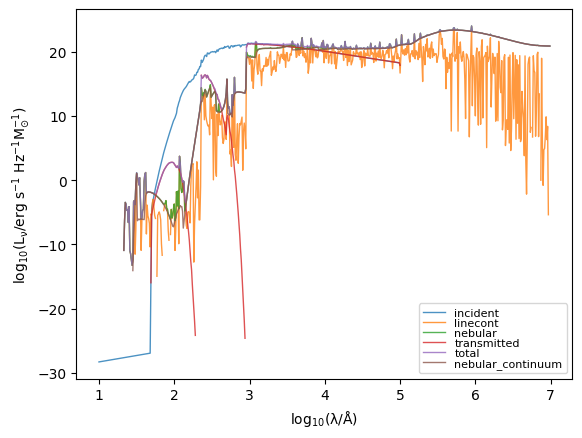

In [6]:
for spectra_id in grid.available_spectra:
    # get Sed object
    sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
    plt.plot(np.log10(sed.lam), np.log10(sed.lnu), lw=1, alpha=0.8, label=spectra_id)
    
plt.legend(fontsize=8, labelspacing=0.0)
plt.xlabel(r'$\rm log_{10}(\lambda/\AA)$')
plt.ylabel(r'$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$')

### Plot ionising luminosities

We can also plot properties over the entire age and metallicity grid, such as the ionising luminosity. 

In the examples below we plot ionising luminosities for HI and HeII

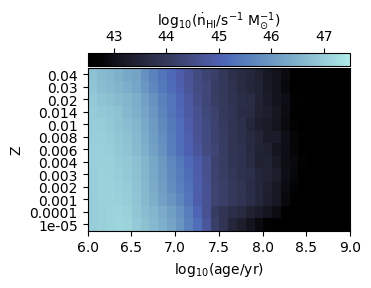

In [7]:
from synthesizer.plots import plot_log10Q

fig, ax = plot_log10Q(grid, ion='HI')

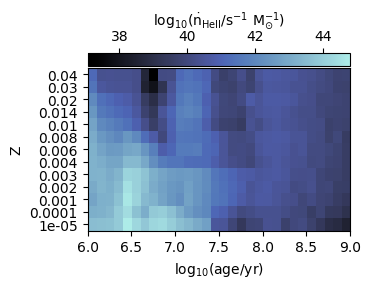

In [8]:
fig, ax = plot_log10Q(grid, ion='HeII')

### 3D grids

This functionality is currently in development - come back soon!

In [9]:
# grid_name = 'test_grid3D'

# grid = Grid(grid_name, grid_dir=grid_dir)
# print(grid)

## Resampling Grids

Some of the available grids have extremely high resolution wavelength grids. In many cases this is overkill and can lead to large memory overheads, while in other situations a particular wavelength grid may be required (matching a spectroscopic survey for instance). To handle these cases a `Grid` can be passed a new wavelength array at the point of instantiation to interpolate the SPS grid spectra onto. 

In [11]:
# Define a new set of wavelengths
new_lams = np.logspace(2, 5, 1000)

print("The old grid had dimensions:", grid.spectra["incident"].shape)

# Get the grid interpolated onto the new wavelength array
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=new_lams)

print("The interpolated grid has dimensions:", grid.spectra["incident"].shape)

The old grid had dimensions: (51, 13, 600)
The interpolated grid has dimensions: (51, 13, 1000)


Note that this will overwrite the spectra and wavelengths read from the file. To get them back a separate `Grid` can be instatiated without the modified wavelength array.